# ***3Δ ΥΠΟΛΟΓΙΣΤΙΚΗ ΓΕΩΜΕΤΡΙΑ ΚΑΙ ΟΡΑΣΗ***
## ΑΠΑΛΛΑΚΤΙΚΗ ΕΡΓΑΣΙΑ 4
### **Camera vs Lidar**

Στόχος της εργασίας είναι να συγκριθούν τεχνικές ανίχνευσης δρόμου και εμποδίων χρησιμοποιώντας δεδομένα κάμερας και αισθητήρα Lidar από το KITTI dataset.

Το dataset μπορεί να βρεθεί στον παρακάτω σύνδεσμο:
https://www.cvlibs.net/datasets/kitti/eval_road.php

Θα αναλυθούν:

## Μέρος Α

### Εισαγωγή βιβλιοθηκών

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from ultralytics import YOLO
from sklearn.decomposition import PCA

# Κλάση ***RoadSegmenter***

In [16]:
class RoadSegmenter:
    def __init__(self, path):
        self.path = path
        self.image = None
        self.gray = None
        self.midline_x = None
        self.result = None

    def load_images(self):
        self.image = cv2.imread(self.path)

        if self.image is None:
            raise ValueError("Could not load the image.")

        # Convert to grayscale
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        # self.gray = clahe.apply(self.gray)
    
    def detect_edges(self):
        blurred = cv2.GaussianBlur(self.gray, (5, 5), 5)
        self.edges = cv2.Canny(blurred, 100, 180)

    def region_grow(self):
        height, width = self.gray.shape
        seed_point = (width // 2, height - 30)
        cv2.circle(self.image, seed_point, 5, (0, 255, 255), -1)

        mask = np.zeros((height + 2, width + 2), np.uint8)
        flooded = self.gray.copy()
        cv2.floodFill(flooded, mask, seed_point, 125, loDiff=5, upDiff=5, flags=8)
        self.region = mask[1:-1, 1:-1]
        
        # Cut 40 % of top of the image
        cutoff_row = int(height * 0.4)
        self.region[:cutoff_row, :] = 0
        
        self.filled_region = cv2.morphologyEx(self.region, cv2.MORPH_CLOSE, np.ones((6, 6), np.uint8))

    def colorize_lanes(self, alpha=0.2):
        road_mask = self.filled_region.astype(np.uint8) * 255
        height, width = road_mask.shape
        midline = np.zeros_like(road_mask)
        left_mask = np.zeros_like(road_mask)
        right_mask = np.zeros_like(road_mask)

        mid_x_vals = []

        for y in range(height):
            x_coords = np.where(road_mask[y] == 255)[0]
            if len(x_coords) > 1:
                x_left = x_coords[0]
                x_right = x_coords[-1]
                x_mid = (x_left + x_right) // 2
                mid_x_vals.append(x_mid)
            else:
                mid_x_vals.append(-1)

        # Savitzky-Golay
        mid_x_vals = np.array(mid_x_vals)
        valid_indices = np.where(mid_x_vals != -1)[0]
        smoothed = mid_x_vals.copy()
        if len(valid_indices) > 5:
            smoothed[valid_indices] = savgol_filter(mid_x_vals[valid_indices], window_length=21, polyorder=2)

        for i, x in enumerate(smoothed):
            if x != -1:
                x = int(x)
                midline[i, x] = 255
                for j in np.where(road_mask[i] == 255)[0]:
                    if j < x:
                        left_mask[i, j] = 1
                    elif j > x:
                        right_mask[i, j] = 1

        # Overlay image
        overlay = np.zeros_like(self.image, dtype=np.uint8)

        # Color the lanes
        overlay[road_mask == 0] = [255, 0, 0]
        overlay[(road_mask == 255) & (left_mask == 1)] = [0, 255, 0]
        overlay[(road_mask == 255) & (right_mask == 1)] = [0, 0, 255]
        overlay[midline == 255] = [255, 255, 255]

        self.result = cv2.addWeighted(self.image, 1 - alpha, overlay, alpha, 0)

    def detect_obstacles(self, model_path="yolov8n.pt", conf_threshold=0.3):
        # Load YOLO model
        model = YOLO(model_path)

        # Detect objects in the image
        results = model(self.image)[0]
        self.obstacles = []

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            conf = float(box.conf)
            if conf < conf_threshold:
                continue

            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(self.filled_region.shape[1] - 1, x2)
            y2 = min(self.filled_region.shape[0] - 1, y2)

            obj_mask = self.filled_region[y1:y2, x1:x2]
            if np.any(obj_mask > 0):
                self.obstacles.append((x1, y1, x2, y2))

                cv2.rectangle(self.result, (x1, y1), (x2, y2), (0, 255, 255), 2)

        print(f"Found {len(self.obstacles)} obstacles intersecting the road.")

    def compute_motion_vector_pca(self):
        height, width = self.filled_region.shape
        mid_points = []

        for y in range(height - 1, 0, -1):
            x_vals = np.where(self.filled_region[y] == 1)[0]
            if len(x_vals) > 1:
                x_mid = (x_vals[0] + x_vals[-1]) // 2
                mid_points.append([x_mid, y])

        if len(mid_points) < 2:
            print("Not enough midline points for PCA.")
            return

        mid_points = np.array(mid_points)

        # PCA
        pca = PCA(n_components=2)
        pca.fit(mid_points)
        direction = pca.components_[0]

        if direction[1] > 0:
            direction = -direction

        center = np.mean(mid_points, axis=0).astype(int)
        
        if len(self.obstacles) == 0:
            scale = 100
            end_point = (int(center[0] + scale * direction[0]), int(center[1] + scale * direction[1]))
            cv2.arrowedLine(self.result, tuple(center), end_point, (255, 255, 255), 3, tipLength=0.2)
        else:
            cv2.circle(self.result, tuple(center), 30, (0, 0, 255), thickness=3)
            cv2.putText(self.result, "Obstacle Ahead", (center[0] - 50, center[1] - 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

        print(f"Midline PCA vector: {direction}")

    def show_results(self):
        fig, axes = plt.subplots(3, 1, figsize=(8, 15))
    
        # Original Image
        axes[0].imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')
    
        # Segmented Region
        axes[1].imshow(self.filled_region, cmap='gray')
        axes[1].set_title("Segmented Road Region", fontsize=14, fontweight='bold')
        axes[1].axis('off')
    
        # Final result
        axes[2].imshow(cv2.cvtColor(self.result, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Detected Lanes", fontsize=14, fontweight='bold')
        axes[2].axis('off')
    
        plt.tight_layout()
        plt.show()

    def save_results(self, path):
        # Save Result
        save_dir = "saved_images/partA"
        os.makedirs(save_dir, exist_ok=True)

        base_name = os.path.basename(path)
        save_path = os.path.join(save_dir, base_name)

        cv2.imwrite(save_path, self.result)
        print(f"Image saved as: {save_path}")

    def run(self):
        # Load Both Left and Right Images and convert to grayscale
        self.load_images()
        # a) Using growing region
        self.detect_edges()
        self.region_grow()
        self.colorize_lanes()
        
        # b) Detect obstacles using YOLO
        self.detect_obstacles()
        
        # c) Compute motion vector using PCA
        self.compute_motion_vector_pca()
        
        self.show_results()
    


# Καθορισμός διαδρομών των εικόνων (path)

In [17]:
path = "image_2/um_000000.png"

# Δημιουργία Αντικειμένου segmenter τύπου RoadSegmenter

In [18]:
segmenter = RoadSegmenter(path)

In [19]:
segmenter.load_images()

In [20]:
segmenter.detect_edges()
segmenter.region_grow()
segmenter.colorize_lanes()

In [21]:
segmenter.detect_obstacles()


0: 224x640 1 person, 1 bicycle, 47.2ms
Speed: 2.0ms preprocess, 47.2ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
Found 0 obstacles intersecting the road.


In [22]:
segmenter.compute_motion_vector_pca()

Midline PCA vector: [   0.076114     -0.9971]


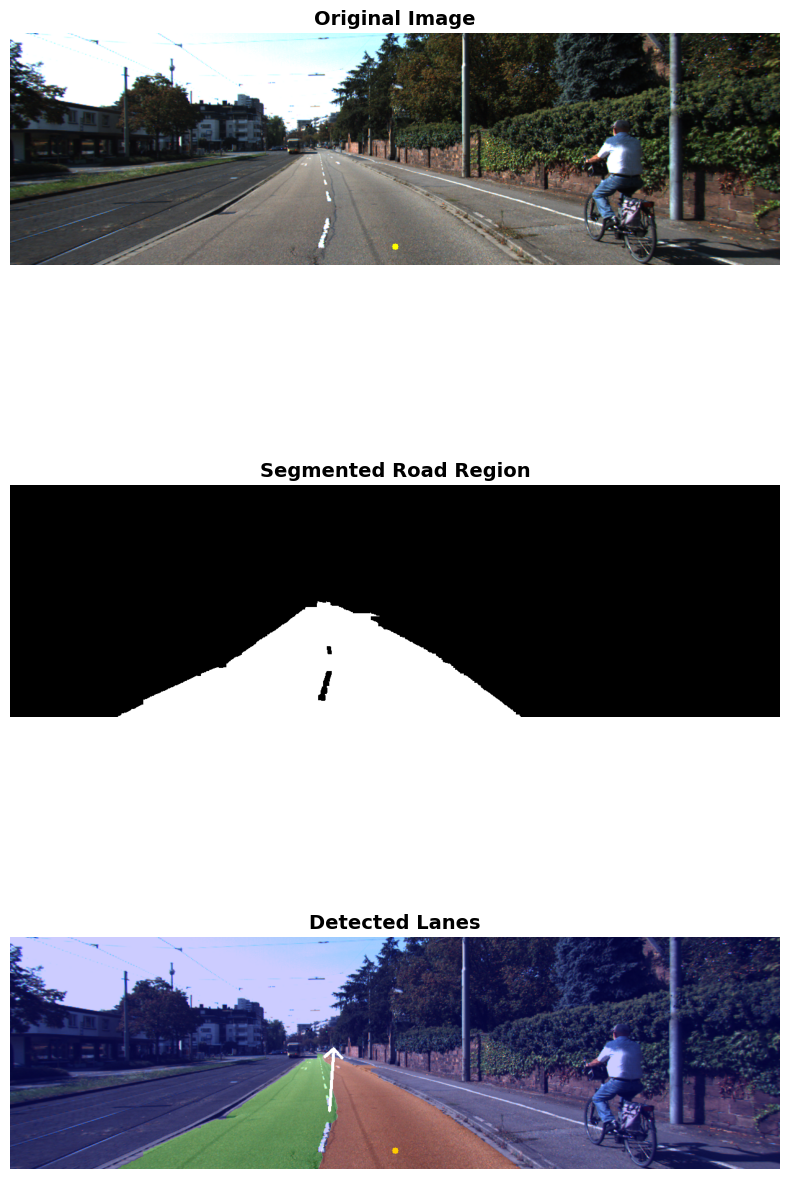

In [23]:
segmenter.show_results()

# Μέρος Β